In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from pathlib import Path
import numpy as np

# Directory paths for train, validation, and test sets
dataset = Path('/content/drive/MyDrive/disease')
train_dir = '/content/drive/MyDrive/disease/train'
val_dir = '/content/drive/MyDrive/disease/val'
test_dir = '/content/drive/MyDrive/disease/test'

# Image dimensions
img_height = 224
img_width = 224
RANDOM_SEED = 42

In [ ]:
# Image dimensions
img_height = 224
img_width = 224
RANDOM_SEED = 42
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.convnext import preprocess_input

IMG_SIZE = 224

# Custom preprocessing function for MobileNetV2
def convnext_preprocess(img):
    return preprocess_input(img)  # Converts to [-1, 1]

# ImageDataGenerator for data augmentation and correct normalization
datagen = ImageDataGenerator(
    preprocessing_function=convnext_preprocess,  # Use convnext preprocessing
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
def walk_dir(dataset):
    for dirpath, dirnames, filenames in os.walk(dataset):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_dir(dataset)

There are 3 directories and 0 images in '/content/drive/MyDrive/disease'.
There are 5 directories and 0 images in '/content/drive/MyDrive/disease/val'.
There are 0 directories and 406 images in '/content/drive/MyDrive/disease/val/Corona Virus Disease'.
There are 0 directories and 401 images in '/content/drive/MyDrive/disease/val/Viral Pneumonia'.
There are 0 directories and 402 images in '/content/drive/MyDrive/disease/val/Normal'.
There are 0 directories and 406 images in '/content/drive/MyDrive/disease/val/Tuberculosis'.
There are 0 directories and 401 images in '/content/drive/MyDrive/disease/val/Bacterial Pneumonia'.
There are 5 directories and 0 images in '/content/drive/MyDrive/disease/train'.
There are 0 directories and 1204 images in '/content/drive/MyDrive/disease/train/Viral Pneumonia'.
There are 0 directories and 1205 images in '/content/drive/MyDrive/disease/train/Bacterial Pneumonia'.
There are 0 directories and 1207 images in '/content/drive/MyDrive/disease/train/Normal'.

In [ ]:
import cv2
import numpy as np

def apply_clahe(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image_gray)

array([[ 64,  64,  67, ...,  63,  63,  63],
       [ 67,  69,  72, ...,  66,  63,  63],
       [ 69,  74,  77, ...,  69,  66,  66],
       ...,
       [156, 156, 158, ..., 172, 169, 167],
       [153, 156, 158, ..., 172, 169, 167],
       [153, 153, 158, ..., 172, 169, 169]], dtype=uint8)
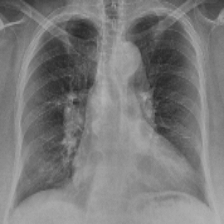

In [ ]:
IMG_SIZE = 224

def get_Image():
    image_path_list = list(dataset.glob("*/*/*.*"))
    sample_path = image_path_list[0]
    img = cv2.imread(str(sample_path))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = apply_clahe(img)
    return sample_path.name, img
_, img = get_Image()
img

<Figure size 1000x1000 with 0 Axes>

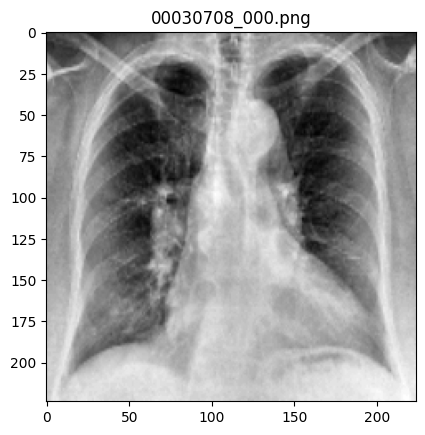

<Figure size 1000x1000 with 0 Axes>

In [ ]:
title, img = get_Image()
img_arr = np.asarray(img)

plt.imshow(img_arr, cmap='gray') #Always show black and white images
plt.title(title)
plt.figure(figsize=(10,10))

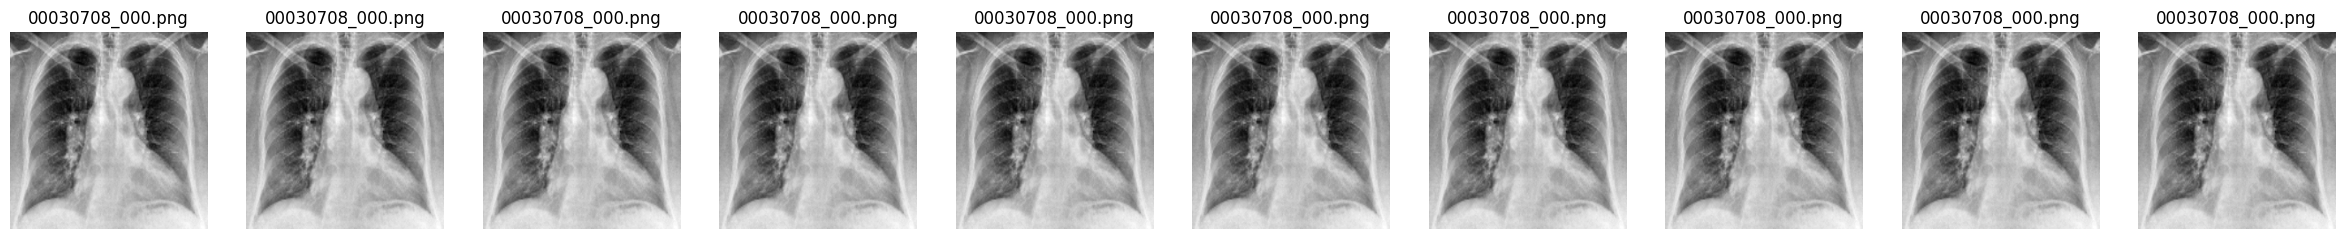

In [ ]:
def Show_Images(n_img):
    fig, axes = plt.subplots(1, n_img, figsize=(30, 20))
    axes = axes.flatten()  # Flatten axes for easy indexing

    # Loop through images and display them
    for i in range(n_img):
        title, img = get_Image()
        img = np.asarray(img)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis("off")  # Hide axes
Show_Images(10)

In [ ]:
# Training data generator
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical'  # Use 'categorical' for string labels (one-hot encoding)
)


# Validation data generator
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical'  # Use 'categorical' for string labels (one-hot encoding)
)

# Test data generator
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical'  # Use 'categorical' for string labels (one-hot encoding)
)

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # Import necessary layers

base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False # Bekukan seluruh model dasar

x = base_model.output
    # Gunakan GlobalAveragePooling2D seperti saran sebelumnya
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='gelu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

learning_rate = 0.001 # Tingkat pembelajaran yang sedikit lebih tinggi untuk fase ini
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Latih model selama beberapa epoch (misal 10-20 epoch)
r_frozen = model.fit(train_gen, validation_data=val_gen, epochs=20, batch_size=16, verbose=2)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
379/379 - 6180s - 16s/step - accuracy: 0.7468 - loss: 0.6232 - val_accuracy: 0.7996 - val_loss: 0.4591
Epoch 2/20
379/379 - 150s - 397ms/step - accuracy: 0.7980 - loss: 0.4827 - val_accuracy: 0.8373 - val_loss: 0.4014
Epoch 3/20
379/379 - 151s - 399ms/step - accuracy: 0.8114 - loss: 0.4564 - val_accuracy: 0.8467 - val_loss: 0.3938
Epoch 4/20
379/379 - 151s - 398ms/step - accuracy: 0.8292 - loss: 0.4207 - val_accuracy: 0.8433 - val_loss: 0.3892
Epoch 5/20
379/379 - 151s - 399ms/step - accuracy: 0.8219 - loss: 0.4108 - val_accuracy: 0.8145 - val_loss: 0.4128
Epoch 6/20
379/379 - 151s - 399ms/step - accuracy: 0.8342 - loss: 0.4008 - val_accuracy: 0.8547 - val_loss: 0.3848
Epoch 7/20
379/379 - 151s - 399ms/step - accuracy: 0.8360 - loss: 0.3905 - val_accuracy: 0.8591 - val_loss: 0.3585
Epoch 8/20
379/379 - 151s - 399ms/step - accuracy: 0.8406 - loss: 0.3906 - val_accuracy: 0.8537 - val_loss: 0.3580
Epoch 9/20
379/379 - 151s - 399ms/step - accuracy: 0.8409 - loss: 0.3767 - val_ac

In [ ]:
# Buka sebagian layer dari base_model
base_model.trainable = True
fine_tune_from = 50 # Sesuaikan nilai ini - Anda perlu mencari tahu berapa banyak layer terakhir yang ingin di-unfreeze
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False # Bekukan layer-layer awal

    # Kompilasi ulang model dengan learning rate yang sangat rendah
learning_rate = 0.00001 # Jauh lebih rendah!
optimizer = Adam(learning_rate=learning_rate) # Bisa juga gunakan optimizer lain seperti SGD dengan momentum
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Lanjutkan pelatihan selama lebih banyak epoch (misal 40-60 epoch lagi)
    # Anda bisa melanjutkan pelatihan dari bobot yang sudah dilatih di fase 1
r_fine_tune = model.fit(train_gen, validation_data=val_gen, epochs=70, # Total epoch 60 (20 + 40)
                        initial_epoch=r_frozen.epoch[-1], # Mulai dari akhir epoch fase 1
                        batch_size=16, verbose=2)

    # Anda bisa menggabungkan history dari kedua fase pelatihan untuk plotting

Epoch 20/70
379/379 - 268s - 708ms/step - accuracy: 0.8715 - loss: 0.3181 - val_accuracy: 0.8839 - val_loss: 0.3031
Epoch 21/70
379/379 - 152s - 401ms/step - accuracy: 0.8869 - loss: 0.2745 - val_accuracy: 0.8864 - val_loss: 0.2810
Epoch 22/70
379/379 - 154s - 405ms/step - accuracy: 0.8948 - loss: 0.2598 - val_accuracy: 0.8854 - val_loss: 0.2773
Epoch 23/70
379/379 - 153s - 404ms/step - accuracy: 0.9025 - loss: 0.2414 - val_accuracy: 0.8874 - val_loss: 0.2671
Epoch 24/70
379/379 - 153s - 405ms/step - accuracy: 0.9098 - loss: 0.2222 - val_accuracy: 0.9013 - val_loss: 0.2512
Epoch 25/70
379/379 - 154s - 407ms/step - accuracy: 0.9133 - loss: 0.2167 - val_accuracy: 0.8938 - val_loss: 0.2523
Epoch 26/70
379/379 - 154s - 406ms/step - accuracy: 0.9191 - loss: 0.2064 - val_accuracy: 0.8909 - val_loss: 0.2477
Epoch 27/70
379/379 - 153s - 405ms/step - accuracy: 0.9202 - loss: 0.1936 - val_accuracy: 0.9077 - val_loss: 0.2332
Epoch 28/70
379/379 - 153s - 404ms/step - accuracy: 0.9232 - loss: 0.176

In [ ]:
import pandas as pd
#save history
# Use the variable where the history was actually stored, e.g., r_fine_tune
hist_df = pd.DataFrame(r_fine_tune.history)
# or save to csv:
hist_csv_file = 'model_convnext_new_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#save model
model.save('model_convnext_new_lung.h5')

#save weights
model.save_weights('model_convnext_new_lung_.weights.h5')

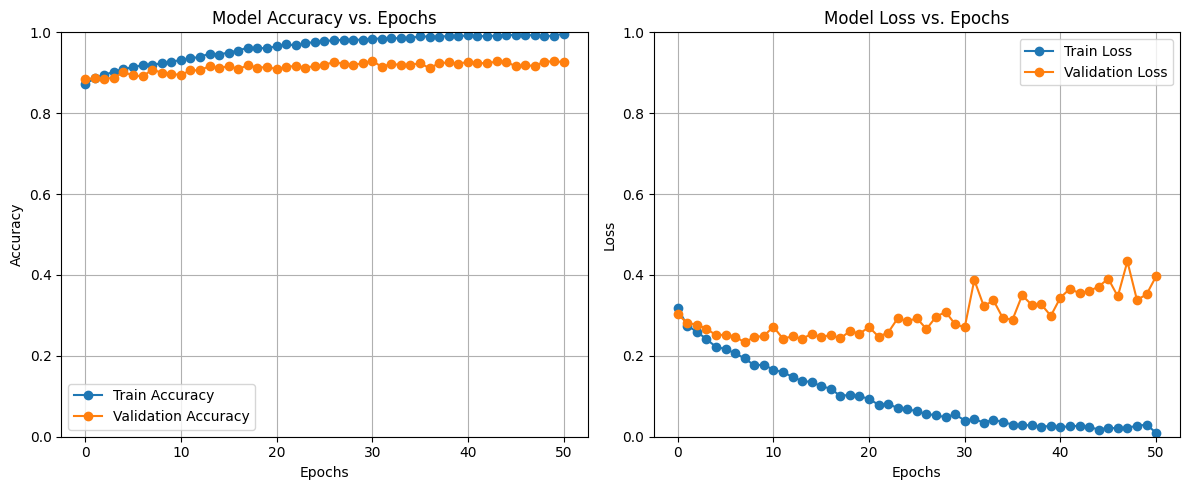

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'r.history' contains the training history
history = r_fine_tune.history

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.0, 1.0)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0.0, 1.0)
# Show the plots
plt.tight_layout()
plt.show()

Found 2025 images belonging to 5 classes.
64/64 ━━━━━━━━━━━━━━━━━━━━ 1434s 22s/step
Overall Evaluation Metrics:


,Metric,Score
0,Accuracy,0.863210
1,Precision,0.880936
2,Recall,0.863210
3,F1-Score,0.860240



Evaluation Metrics per Class:


,precision,recall,f1-score,support
Bacterial Pneumonia,0.938697,0.607940,0.737952,403.00000
Corona Virus Disease,0.859275,0.990172,0.920091,407.00000
Normal,0.909297,0.992574,0.949112,404.00000
Tuberculosis,1.000000,0.843137,0.914894,408.00000
Viral Pneumonia,0.696078,0.880893,0.777656,403.00000
accuracy,0.863210,0.863210,0.863210,0.86321
macro avg,0.880670,0.862943,0.859941,2025.00000
weighted avg,0.880936,0.863210,0.860240,2025.00000


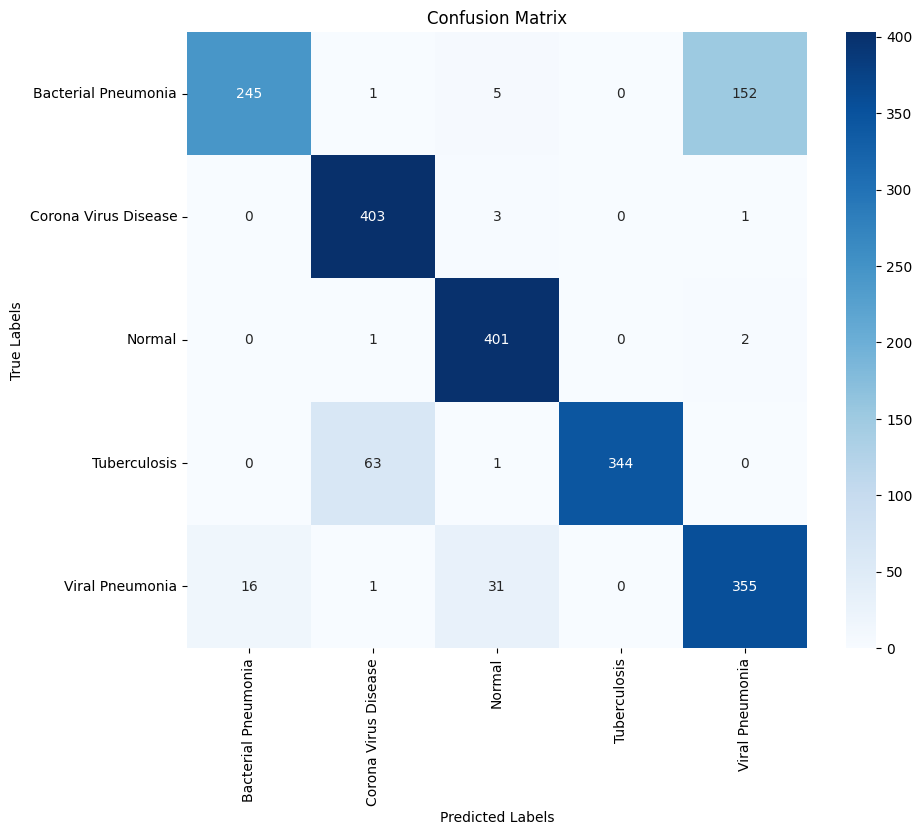

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. Buat test generator tanpa augmentasi ---
test_datagen = ImageDataGenerator(preprocessing_function=convnext_preprocess)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False  # penting agar urutan gambar sesuai dengan label
)

# --- 2. Ambil label dari train_gen untuk menjaga konsistensi urutan ---
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]

# --- 3. Prediksi ---
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)

# --- 4. Konversi prediksi probabilitas ke label ---
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

# --- 5. Hitung metrik ---
overall_accuracy = accuracy_score(true_classes, predicted_classes)
overall_precision = precision_score(true_classes, predicted_classes, average='weighted')
overall_recall = recall_score(true_classes, predicted_classes, average='weighted')
overall_f1 = f1_score(true_classes, predicted_classes, average='weighted')

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [overall_accuracy, overall_precision, overall_recall, overall_f1]
})

print("Overall Evaluation Metrics:")
display(metrics_df)

# --- 6. Metrik per kelas ---
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\nEvaluation Metrics per Class:")
display(report_df)

# --- 7. Confusion Matrix ---
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


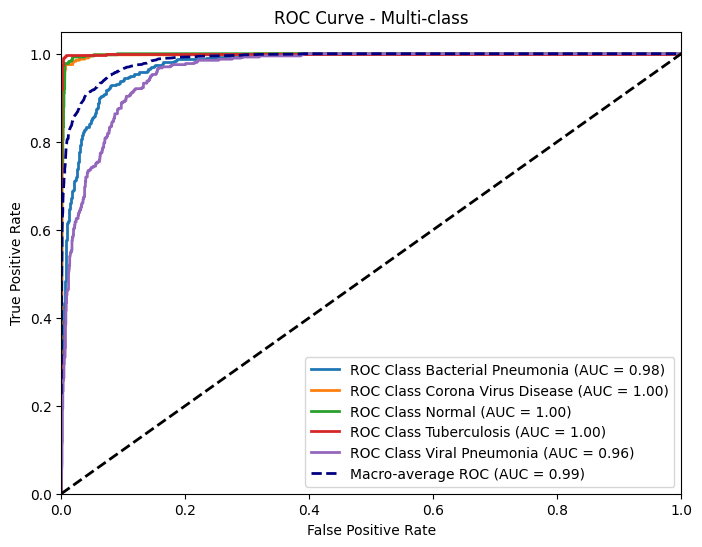

Macro-average ROC AUC: 0.9868500725922164


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# === 1. One-hot encode label asli ===
y_test_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))

# === 2. Hitung ROC curve & AUC per kelas ===
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === 3. Hitung macro-average ROC ===
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# === 4. Visualisasi ===
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--',
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

print("Macro-average ROC AUC:", roc_auc["macro"])


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Pastikan matplotlib diimpor

# Function to preprocess the uploaded image
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB') # Pastikan gambar dalam format RGB
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Apply the same preprocessing function used during training
    # Pastikan convnext_preprocess sudah terdefinisi dari sel sebelumnya
    img_array = convnext_preprocess(img_array)
    return img_array

# Function to predict the class of the image
def predict_image_class(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(predictions)
    return predicted_class, confidence

# Get class labels from the training generator
# Ensure you run the cell with train_gen definition before this
# Anda perlu memastikan variabel train_gen masih tersedia dari sel sebelumnya
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]


# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    # Get the image path
    img_path = fn

    # Preprocess the image
    processed_img_array = preprocess_image(img_path)

    # Predict the class
    # Gunakan objek model yang ada di memori (dari sel pelatihan)
    predicted_class, confidence = predict_image_class(model, processed_img_array, class_labels)

    # Display the image and prediction
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img, cmap='gray') # Tampilkan gambar (dalam skala abu-abu jika sesuai)
    plt.title(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

Saving 0.jpeg to 0.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


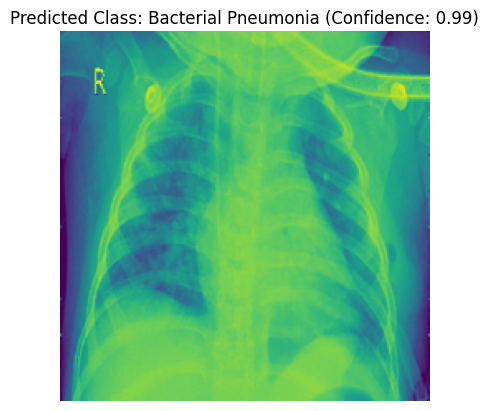

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


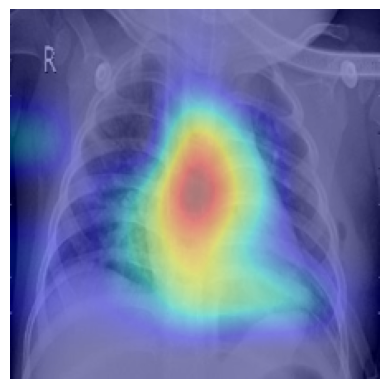

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# --------------------------
# Fungsi untuk preprocessing
# --------------------------


def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.uint8)

    # CLAHE
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_array = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    img_array = image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = convnext_preprocess(img_array)
    return img_array


# --------------------------
# Fungsi prediksi
# --------------------------
def predict_image_class(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(predictions)
    return predicted_class, confidence, predicted_class_index

# --------------------------
# Fungsi Grad-CAM
# --------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size)
    heatmap = np.array(heatmap)

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # overlay heatmap
    plt.axis('off')
    plt.show()

# --------------------------
# Ambil label dari train_gen
# --------------------------
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]

# --------------------------
# Upload dan Prediksi
# --------------------------
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    processed_img_array = preprocess_image(img_path)

    predicted_class, confidence, pred_index = predict_image_class(model, processed_img_array, class_labels)

    # Tampilkan gambar + prediksi
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]  # cari layer konvolusi terakhir
    heatmap = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index)
    display_gradcam(img_path, heatmap)


Saving 044.jpeg to 044.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


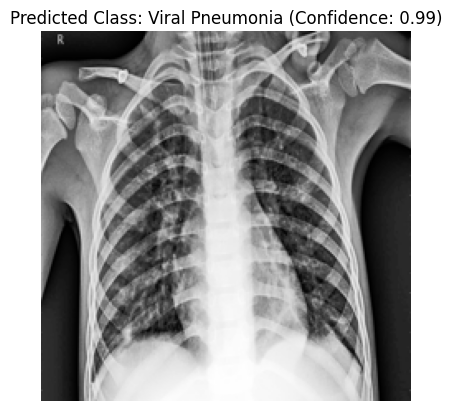

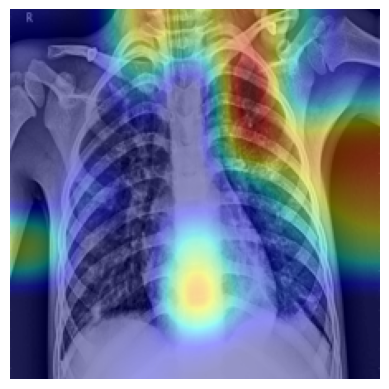

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# --------------------------
# Fungsi untuk preprocessing
# --------------------------


def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.uint8)

    # CLAHE
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_array = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    img_array = image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = convnext_preprocess(img_array)
    return img_array


# --------------------------
# Fungsi prediksi
# --------------------------
def predict_image_class(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(predictions)
    return predicted_class, confidence, predicted_class_index

# --------------------------
# Fungsi Grad-CAM
# --------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size)
    heatmap = np.array(heatmap)

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # overlay heatmap
    plt.axis('off')
    plt.show()

# --------------------------
# Ambil label dari train_gen
# --------------------------
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]

# --------------------------
# Upload dan Prediksi
# --------------------------
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    processed_img_array = preprocess_image(img_path)

    predicted_class, confidence, pred_index = predict_image_class(model, processed_img_array, class_labels)

    # Tampilkan gambar + prediksi
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]  # cari layer konvolusi terakhir
    heatmap = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index)
    display_gradcam(img_path, heatmap)


Saving 00030370_001.png to 00030370_001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


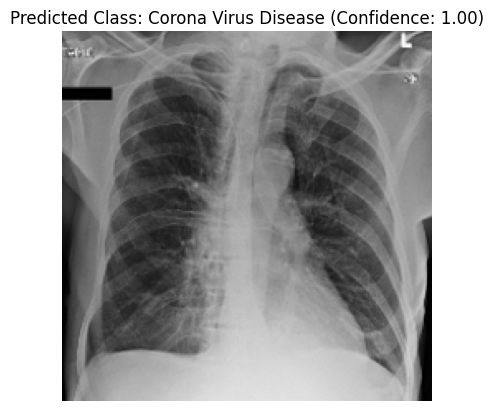

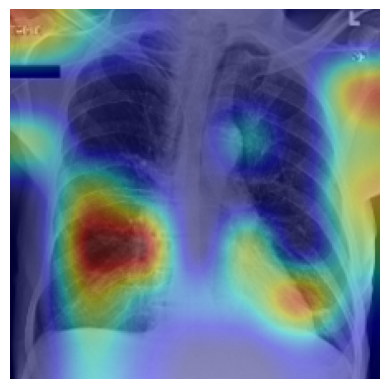

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# --------------------------
# Fungsi untuk preprocessing
# --------------------------


def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.uint8)

    # CLAHE
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_array = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    img_array = image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = convnext_preprocess(img_array)
    return img_array


# --------------------------
# Fungsi prediksi
# --------------------------
def predict_image_class(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(predictions)
    return predicted_class, confidence, predicted_class_index

# --------------------------
# Fungsi Grad-CAM
# --------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size)
    heatmap = np.array(heatmap)

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # overlay heatmap
    plt.axis('off')
    plt.show()

# --------------------------
# Ambil label dari train_gen
# --------------------------
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]

# --------------------------
# Upload dan Prediksi
# --------------------------
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    processed_img_array = preprocess_image(img_path)

    predicted_class, confidence, pred_index = predict_image_class(model, processed_img_array, class_labels)

    # Tampilkan gambar + prediksi
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]  # cari layer konvolusi terakhir
    heatmap = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index)
    display_gradcam(img_path, heatmap)


Saving test_0_3676.jpeg to test_0_3676.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


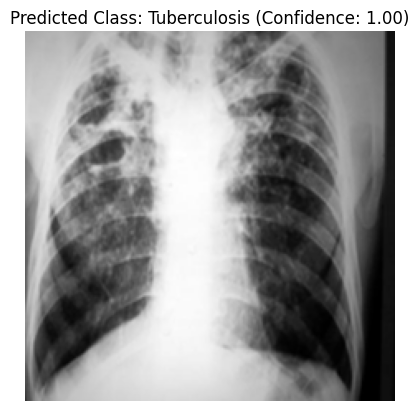

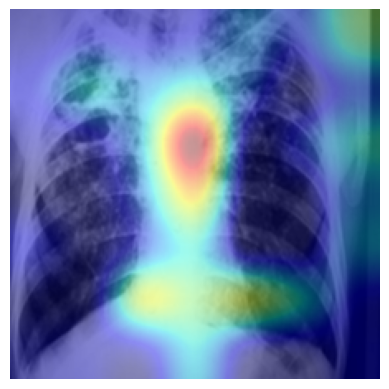

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# --------------------------
# Fungsi untuk preprocessing
# --------------------------


def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.uint8)

    # CLAHE
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_array = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    img_array = image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = convnext_preprocess(img_array)
    return img_array


# --------------------------
# Fungsi prediksi
# --------------------------
def predict_image_class(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(predictions)
    return predicted_class, confidence, predicted_class_index

# --------------------------
# Fungsi Grad-CAM
# --------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size)
    heatmap = np.array(heatmap)

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # overlay heatmap
    plt.axis('off')
    plt.show()

# --------------------------
# Ambil label dari train_gen
# --------------------------
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]

# --------------------------
# Upload dan Prediksi
# --------------------------
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    processed_img_array = preprocess_image(img_path)

    predicted_class, confidence, pred_index = predict_image_class(model, processed_img_array, class_labels)

    # Tampilkan gambar + prediksi
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]  # cari layer konvolusi terakhir
    heatmap = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index)
    display_gradcam(img_path, heatmap)


Saving 018.jpeg to 018.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


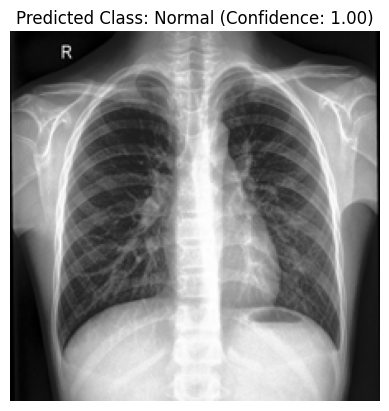

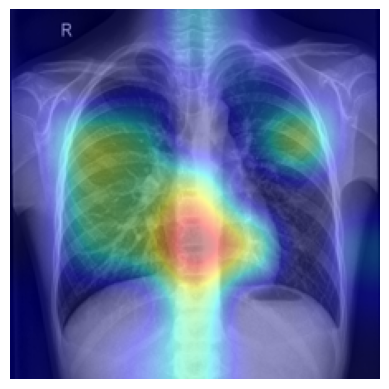

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# --------------------------
# Fungsi untuk preprocessing
# --------------------------


def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.uint8)

    # CLAHE
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_array = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    img_array = image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = convnext_preprocess(img_array)
    return img_array


# --------------------------
# Fungsi prediksi
# --------------------------
def predict_image_class(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(predictions)
    return predicted_class, confidence, predicted_class_index

# --------------------------
# Fungsi Grad-CAM
# --------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size)
    heatmap = np.array(heatmap)

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # overlay heatmap
    plt.axis('off')
    plt.show()

# --------------------------
# Ambil label dari train_gen
# --------------------------
class_labels = list(train_gen.class_indices.keys())
class_labels = [class_labels[i] for i in sorted(train_gen.class_indices.values())]

# --------------------------
# Upload dan Prediksi
# --------------------------
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    processed_img_array = preprocess_image(img_path)

    predicted_class, confidence, pred_index = predict_image_class(model, processed_img_array, class_labels)

    # Tampilkan gambar + prediksi
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]  # cari layer konvolusi terakhir
    heatmap = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index)
    display_gradcam(img_path, heatmap)
